In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

100% 1.06G/1.06G [00:49<00:00, 23.8MB/s]
100% 1.06G/1.06G [00:49<00:00, 23.2MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [6]:
conv_base.trainable = True #here we put trainable = True as for selected ones we have to make it false

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [8]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [9]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [10]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [11]:
model.compile(
    optimizer=keras.optimizers.RMSprop(lr=1e-5), #for fine tuning we make learning rate very less
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [12]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 92s 120ms/step - loss: 1.3772 - accuracy: 0.8136 - val_loss: 0.2210 - val_accuracy: 0.9024
Epoch 2/10
625/625 [==============================] - 81s 128ms/step - loss: 0.1787 - accuracy: 0.9326 - val_loss: 0.1786 - val_accuracy: 0.9384
Epoch 3/10
625/625 [==============================] - 67s 107ms/step - loss: 0.1316 - accuracy: 0.9523 - val_loss: 0.1667 - val_accuracy: 0.9416
Epoch 4/10
625/625 [==============================] - 75s 120ms/step - loss: 0.1079 - accuracy: 0.9654 - val_loss: 0.2429 - val_accuracy: 0.9460
Epoch 5/10
625/625 [==============================] - 75s 120ms/step - loss: 0.0830 - accuracy: 0.9722 - val_loss: 0.4550 - val_accuracy: 0.8914
Epoch 6/10
625/625 [==============================] - 75s 120ms/step - loss: 0.0730 - accuracy: 0.9787 - val_loss: 0.3024 - val_accuracy: 0.9404
Epoch 7/10
625/625 [==============================] - 66s 106ms/step - loss: 0.0593 - accuracy: 0.9836 - val_loss: 0.2829 - val_ac

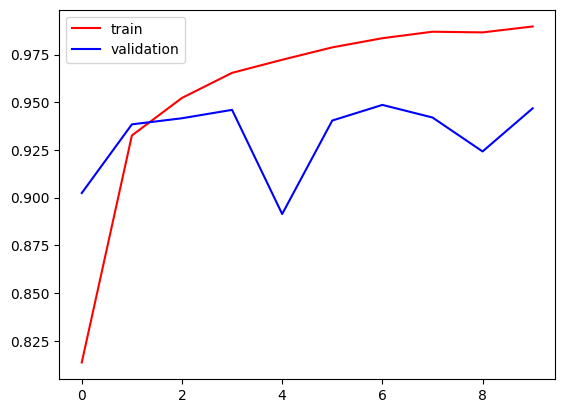

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

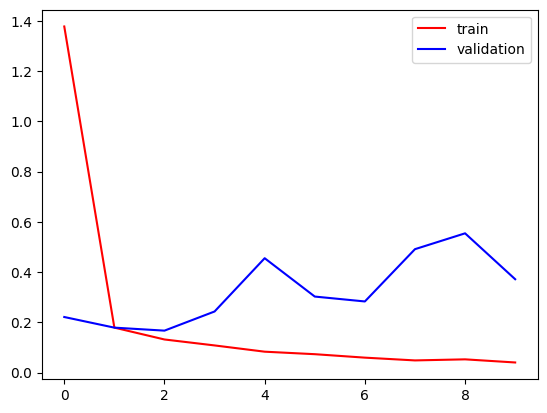

In [14]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()